# <font style="color: rgb(0,0,0);">Option B: </font> <font style="color: rgb(190,138,67);">Transport efficiency</font>

In [7]:
from PIL import Image, ImageTk, ImageMath, ImageOps
Image.MAX_IMAGE_PIXELS = 1000000000
import PIL.ImageGrab as ImageGrab
import cv2
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from io import StringIO
from csv import writer 
from scipy import integrate
import math
import time as time_lib
import xarray as xr
import subprocess
import json
from prettytable import *
import matplotlib.colors as colors

def current_milli_time():
    return round(time_lib.time() * 1000 *1000)

In [8]:
from A_helper_functions import *

# Trajectory / delta-v Estimation for EL3 Sizing

In [9]:
def orb_vel(r):
    return np.sqrt((G * m_moon)/(r)) # [m/s]

def orb_vel_ellip(r,a):
    return np.sqrt((G * m_moon) * ( (2/r)-(1/a) )) # [m/s]

## Ascent/Decent deltaV Estimation

In [10]:
# Map    extrema:   min:    -9.115 [km]   max:    10.757 [km] to reference radius 1737.4 [km]
# Radius extrema:   min:  1728.285 [km]   max:  1748.157 [km]
# Orbital radius:         1750.157 [km]  <- 2 km over highest point
# Altitude  gain:   max:    21.872 [km]   min:     2.000 [km]

min_start_r = 1_728_285 # [m] (max Altitude gain)
max_start_r = 1_748_157 # [m]
orbital_r = 1_750_157 # [m]

# deltaV from start_radius with v=0 to orbital_radius:
# IDEAL SEQUENCE:
#    v1 - instantanious burn to orbital velocity at ground level
#    v2 - Hohman Transfer from start_radius to orbital_radius
# +20% Margin to approach a realistic szenario

print(f'Ascent to {orbital_r - r_moon} [m] altitude circular orbit')
margin = 0.2
a = (min_start_r + orbital_r)/2 # [m] semi major axis of transfer ellipse
v1 = orb_vel(min_start_r)
v2_H1 = orb_vel_ellip(min_start_r,a) - orb_vel(min_start_r)
v2_H2 = orb_vel(orbital_r) - orb_vel_ellip(orbital_r,a)
v2 = abs(v2_H1) + abs(v2_H2)
dv_est = (v1 + v2) * ( 1 + margin) # [m/s]
print(f'Estimated delta-v: {dv_est:0.2f} [m/s]  (ideal {v1+v2:0.2f} [m/s] + 20%)')

# ground velocity as a fuction from location (Lattitude) from angular speed of the moon
def ground_vel(Lat):
    omega = 2 * np.pi / 2.361E6 # [s] = (2pi/27.322 [days])
    v_ground = omega * r_surface(Lat) # [m/s] into direction of turn
    return v_ground

def r_surface(Lat):
    x = (Lat / 90) * r_moon
    r_axis = np.sqrt(r_moon**2 - x**2)
    return r_axis

#test_Lat = np.linspace(-90,90,180)
#test_y = ground_vel(test_Lat)
#plt.plot(test_Lat,test_y)
#plt.show()

print(f'Max groundspeed {ground_vel(0):0.2f} [m/s] Min groundspeed {ground_vel(90):0.2f} [m/s]')
max_ACDC_dv = dv_est + ground_vel(0)
print(f'Max sum delta-v {max_ACDC_dv:0.2f} [m/s]')

Ascent to 12757 [m] altitude circular orbit
Estimated delta-v: 2033.83 [m/s]  (ideal 1694.86 [m/s] + 20%)
Max groundspeed 4.62 [m/s] Min groundspeed 0.00 [m/s]
Max sum delta-v 2038.46 [m/s]


## Maneuver deltaV Estimation

### Destination: Lunar Gateway - NRHO

In [11]:
# IDEAL SEQUENCE:
#    v1 - Hohman Transfer from launch orbital_radius to orbital_radius of NRHO Perigee (circular)
#    v2 - instantanious burn to orbital velocity of NHRO at Perigee
NHRO_r_peri = 3_000_000 # [m]
NHRO_r_apo = 70_000_000 # [m]

a = (orbital_r + NHRO_r_peri)/2 # [m] semi major axis of transfer ellipse
v1_H1 = orb_vel_ellip(orbital_r,a) - orb_vel(orbital_r)
v1_H2 = orb_vel(NHRO_r_peri) - orb_vel_ellip(NHRO_r_peri,a)
v1 = abs(v2_H1) + abs(v2_H2)

a = (NHRO_r_apo + NHRO_r_peri)/2 # [m] semi major axis of NRHO ellipse
v2 = orb_vel_ellip(NHRO_r_peri,a) - orb_vel(NHRO_r_peri)
dv_NRHO_est = abs(v1) + abs(v2) # [m/s]

print(f'v1 = {v1:0.2f} [m/s], v2 = {v2:0.2f} [m/s]')
print(f'Maneuvers to NRHO {dv_NRHO_est} [m/s]')

v1 = 10.56 [m/s], v2 = 491.99 [m/s]
Maneuvers to NRHO 502.5501975384061 [m/s]


## EL3 Sizing - Roundtrip Estimation
    → [1] Moon surface: load Payload (O2), refuel O2
    → [2] Transfer (Launch + Maneuvers)
    → [3] Destination: deliver Payload (O2), refuel H2
    → [4] Transfer (Launch + Maneuvers)
    → [1] ...

In [12]:
# EL3 initial data
# https://www.esa.int/Science_Exploration/Human_and_Robotic_Exploration/Exploration/Argonaut_European_Large_Logistics_Lander
EL3_wet_mass  = 8500 # [kg]
EL3_dry_mass  = 3100 # [kg]
EL3_prop_mass = EL3_wet_mass - EL3_dry_mass # [kg]
EL3_payload   = 1500 # [kg]

# EL3 assumptions
EL3_I_sp = 400 # [s] specific impulse


In [13]:
def maneuver_result_mass(EEV,m_0,deltaV):
    # from: deltaV = EEV * ln ( m_0 / m_f )
    m_f = m_0 * (1/ np.exp(deltaV/EEV))
    return m_f

def check_fuel(H2,O2,result_table):
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        return False
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        return False
    else:
        return True

# roundtrip calculation via deltaV
def compute_roundtrip(mass_full, payload, H2_initial, H2_refill, dest_name="Destination",printout=False):
    target_altitude = 12757
    mass_dry = 1600
    of_ratio = 3
    I_sp = 400 # [s] specific impulse
    EEV = np.array(I_sp * g_0, dtype=np.float64) # [m/s] effective exhaust velocity
    
    initial_height = -9115 #-8.179428100585938 # lowest point on downsampled map
    mass = mass_full
    fuel = mass_full - mass_dry - payload
    H2_factor = (1/(of_ratio+1))
    O2_factor = (of_ratio/(of_ratio+1))
    H2 = H2_initial
    O2 = fuel - H2
    
    H2_initial = H2 # for comparing to the end state

    
    #logging in table
    result_table = PrettyTable([" ", "ΔV", "used fuel", "Δ H2", "Δ O2","mass","fuel left","H2","O2","payload"],float_format = "4.0")
    result_table.set_style(MARKDOWN)
    msg = False
    msg_H2 = False
    msg_O2 = False
    
    
    #__________________________________
    # Lunar surface starting condition
    result_table.add_row(["Lunar Surface", "", "", "" , "refill +" , mass, fuel, H2, O2, f'+{payload}' ])
    #__________________________________
    # apply launch segemnt
    
    fuel_used = mass - maneuver_result_mass(EEV,mass,max_ACDC_dv)
    fuel -= fuel_used
    H2 -= H2_factor * fuel_used
    O2 -= O2_factor * fuel_used
    mass = mass_dry + fuel + payload
    
    result_table.add_row(["Launch Segment", max_ACDC_dv , fuel_used, H2_factor * fuel_used, O2_factor * fuel_used, mass, fuel, H2, O2, "" ])
    
    # check if fuel empty
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        if printout: print(result_table, end="\n \n")
        return "O2 empty", msg
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 empty", msg
    
    #__________________________________
    # compute maneuver segment
    manoeuvre_deltaV = 1000.0
    
    fuel_used = mass - maneuver_result_mass(EEV,mass,manoeuvre_deltaV)
    fuel -= fuel_used
    H2 -= H2_factor * fuel_used
    O2 -= O2_factor * fuel_used
    mass = mass_dry + fuel + payload
    
    result_table.add_row([dest_name + " Maneuvers", manoeuvre_deltaV, fuel_used, H2_factor * fuel_used, O2_factor * fuel_used, mass, fuel, H2, O2, "" ])
    
    # check if fuel empty
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        if printout: print(result_table, end="\n \n")
        return "O2 empty", msg
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 empty", msg
    
    # check H2 for optimization
    if H2 < 1 and H2 > 0:
        msg_H2 = True
    if H2 > 1:
        msg = "H2 leftover"
    
    #__________________________________
    # Gateway exchange
    
    H2 += H2_refill
    fuel = O2 + H2
    mass = mass_dry + fuel
    
    result_table.add_row(["Gateway exchange", "", "", "+"+str(H2_refill),"", mass, fuel, H2, O2, "-"+str(payload) ])
    
    # check if fuel empty
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        if printout: print(result_table, end="\n \n")
        return "O2 empty", msg
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 empty", msg
    
    #__________________________________
    # compute orbit segment return
    
    manoeuvre_deltaV = 1000.0
    
    fuel_used = mass - maneuver_result_mass(EEV,mass,manoeuvre_deltaV)
    fuel -= fuel_used
    H2 -= H2_factor * fuel_used
    O2 -= O2_factor * fuel_used
    mass = mass_dry + fuel
    
    result_table.add_row([dest_name + " Maneuvers", manoeuvre_deltaV, fuel_used, H2_factor * fuel_used, O2_factor * fuel_used, mass, fuel, H2, O2, "" ])
    
    # check if fuel empty
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        if printout: print(result_table, end="\n \n")
        return "O2 empty", msg
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 empty", msg
    
    #__________________________________
    # compute landing segment return
    
    fuel_used = mass - maneuver_result_mass(EEV,mass,max_ACDC_dv)
    fuel -= fuel_used
    H2 -= H2_factor * fuel_used
    O2 -= O2_factor * fuel_used
    mass = mass_dry + fuel + payload
    
    result_table.add_row(["Landing Segment", max_ACDC_dv , fuel_used, H2_factor * fuel_used, O2_factor * fuel_used, mass, fuel, H2, O2, "" ])
    
    # check if fuel empty
    if O2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "", "EMPTY", "" ])
        if printout: print(result_table, end="\n \n")
        return "O2 empty", msg
    elif H2 < 0:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 empty", msg
    
    if H2 < H2_initial:
        result_table.add_row(["ABORT", "", "", "" , "" , "", "", "EMPTY", "", "" ])
        if printout: print(result_table, end="\n \n")
        return "H2 insufficient", msg
    
    # check O2 for optimization
    if O2 < 1 and O2 > 0:
        msg_O2 = True
    if O2 > 1:
        msg = "O2 leftover"
    
    if msg_H2 == True and msg_O2 == True:
        msg = True
    
    result_table.add_row(["=== SUCCESS ===", "====", "====", "====" , "====" , "====", "====", "====", "====", "====" ])
    if printout: print(result_table, end="\n \n")
    return True, msg

    
def converge_NRHO_roundtrip(payload,dest_name="NRHO",silent=False):
    # init values
    wet_mass_loop = 2*payload # for faster convergence
    H2_initial_loop = 100
    H2_refill_loop = 100
    
    while True:
        ans, msg = False, False
        ans, msg = compute_roundtrip(wet_mass_loop,payload,H2_initial_loop,H2_refill_loop,dest_name)
        if ans == "O2 empty":
            if payload > 20000: wet_mass_loop += 100 # for faster convergence with big rockets
            else: wet_mass_loop += 1
        if ans == "H2 empty":
            H2_initial_loop += 1
            H2_refill_loop += 1
        if ans == "H2 insufficient":
            H2_refill_loop += 1
        if msg == "H2 leftover":
            H2_initial_loop -= 1
        if msg == "O2 leftover":
            wet_mass_loop -= 1
        
        if not silent: print(f'{wet_mass_loop:5.0f} {H2_initial_loop:5.0f} {H2_refill_loop:5.0f} {bool(ans)} {bool(msg)}', end=" \r") # for debugging
            
        if ans == True and msg == True:
            if not silent: print()
            break


    if not silent: compute_roundtrip(wet_mass_loop,payload,H2_initial_loop,H2_refill_loop,dest_name,printout=True)
    
    return H2_refill_loop
    
# normal EL3 config is insufficient
#compute_roundtrip(mass_full=8500,payload=1500,H2_refill=1500,dest_name="NRHO",printout=True)

# call a converger to return the setup that sucessfuly delivers x [kg] of payload
#converge_roundtrip(0,"NRHO")



#converge_roundtrip(20020,"NRHO")

In [14]:
# Standard El3 Payload
converge_NRHO_roundtrip(1500)

13146  1772  2758 True True         
|                  |  ΔV  | used fuel |  Δ H2 |   Δ O2   |  mass | fuel left |  H2  |  O2  | payload |
|:----------------:|:----:|:---------:|:-----:|:--------:|:-----:|:---------:|:----:|:----:|:-------:|
|  Lunar Surface   |      |           |       | refill + | 13146 |   10046   | 1772 | 8274 |  +1500  |
|  Launch Segment  | 2038 |    5328   |  1332 |   3996   |  7818 |    4718   |  440 | 4278 |         |
|  NRHO Maneuvers  | 1000 |    1759   |   440 |   1319   |  6059 |    2959   |    0 | 2959 |         |
| Gateway exchange |      |           | +2758 |          |  7317 |    5717   | 2758 | 2959 |  -1500  |
|  NRHO Maneuvers  | 1000 |    1647   |   412 |   1235   |  5670 |    4070   | 2347 | 1724 |         |
| Landing Segment  | 2038 |    2298   |   575 |   1724   |  4872 |    1772   | 1772 |    0 |         |
| === SUCCESS ===  | ==== |    ====   |  ==== |   ====   |  ==== |    ====   | ==== | ==== |   ====  |
 


2758

In [15]:
# Exchange Ratio 1:1
converge_NRHO_roundtrip(4060)

20618  2779  4060 True True         
|                  |  ΔV  | used fuel |  Δ H2 |   Δ O2   |  mass | fuel left |  H2  |   O2  | payload |
|:----------------:|:----:|:---------:|:-----:|:--------:|:-----:|:---------:|:----:|:-----:|:-------:|
|  Lunar Surface   |      |           |       | refill + | 20618 |   14958   | 2779 | 12179 |  +4060  |
|  Launch Segment  | 2038 |    8356   |  2089 |   6267   | 12262 |    6602   |  690 |  5912 |         |
|  NRHO Maneuvers  | 1000 |    2759   |   690 |   2069   |  9503 |    3843   |    0 |  3843 |         |
| Gateway exchange |      |           | +4060 |          |  9503 |    7903   | 4060 |  3843 |  -4060  |
|  NRHO Maneuvers  | 1000 |    2138   |   535 |   1604   |  7364 |    5764   | 3526 |  2239 |         |
| Landing Segment  | 2038 |    2985   |   746 |   2238   |  8440 |    2780   | 2779 |     0 |         |
| === SUCCESS ===  | ==== |    ====   |  ==== |   ====   |  ==== |    ====   | ==== |  ==== |   ====  |
 


4060

In [53]:
# Exchange Ratio 1.5:1
converge_NRHO_roundtrip(12620)

45599  6146  8411 True True                 
|                  |  ΔV  | used fuel |  Δ H2 |   Δ O2   |  mass | fuel left |  H2  |   O2  | payload |
|:----------------:|:----:|:---------:|:-----:|:--------:|:-----:|:---------:|:----:|:-----:|:-------:|
|  Lunar Surface   |      |           |       | refill + | 45599 |   31379   | 6146 | 25233 |  +12620 |
|  Launch Segment  | 2038 |   18480   |  4620 |  13860   | 27119 |   12899   | 1526 | 11373 |         |
|  NRHO Maneuvers  | 1000 |    6102   |  1526 |   4577   | 21016 |    6796   |    0 |  6796 |         |
| Gateway exchange |      |           | +8411 |          | 16807 |   15207   | 8411 |  6796 |  -12620 |
|  NRHO Maneuvers  | 1000 |    3782   |   946 |   2837   | 13025 |   11425   | 7466 |  3959 |         |
| Landing Segment  | 2038 |    5279   |  1320 |   3959   | 20366 |    6146   | 6146 |     0 |         |
| === SUCCESS ===  | ==== |    ====   |  ==== |   ====   |  ==== |    ====   | ==== |  ==== |   ====  |
 


8411

In [68]:
# Exchange Ratio 1.75:1
converge_NRHO_roundtrip(31790)

101562 13689 18165 True True       
|                  |  ΔV  | used fuel |  Δ H2  |   Δ O2   |  mass  | fuel left |   H2  |   O2  | payload |
|:----------------:|:----:|:---------:|:------:|:--------:|:------:|:---------:|:-----:|:-----:|:-------:|
|  Lunar Surface   |      |           |        | refill + | 101562 |   68172   | 13689 | 54483 |  +31790 |
|  Launch Segment  | 2038 |   41161   | 10290  |  30871   | 60401  |   27011   |  3399 | 23612 |         |
|  NRHO Maneuvers  | 1000 |   13592   |  3398  |  10194   | 46809  |   13419   |     1 | 13418 |         |
| Gateway exchange |      |           | +18165 |          | 33184  |   31584   | 18166 | 13418 |  -31790 |
|  NRHO Maneuvers  | 1000 |    7467   |  1867  |   5601   | 25717  |   24117   | 16299 |  7818 |         |
| Landing Segment  | 2038 |   10422   |  2606  |   7817   | 47084  |   13694   | 13693 |     1 |         |
| === SUCCESS ===  | ==== |    ====   |  ====  |   ====   |  ====  |    ====   |  ==== |  ==== |   ====  |
 

18165

In [75]:
# plotting
x_payload = np.linspace(1,100000,100)
y = []
for i in tqdm(x_payload):
    y.append(converge_NRHO_roundtrip(i,silent=True))
x = np.array(x_payload)
y = np.array(y)
y_ratio = x/y

x_points = [1500,4060,12620,31790]
y_points = []
for i in tqdm(x_points):
    y_points.append(converge_NRHO_roundtrip(i,silent=True))
x_points = np.array(x_points)
y_points = np.array(y_points)
y_points_ratio = x_points/y_points

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.03it/s]


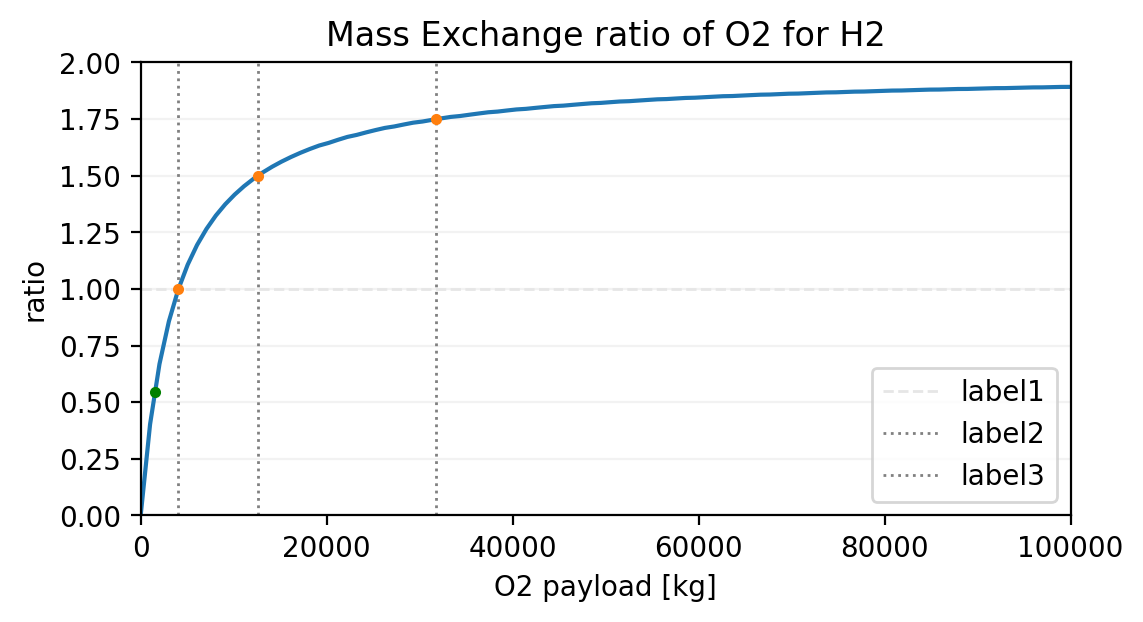

In [118]:
plt.figure(figsize=(6,3), dpi=200)
plt.title("Mass Exchange ratio of O2 for H2")
plt.xlim(0, max(x_payload))
plt.ylim(0, 2)
plt.grid(axis='y', color='0.95')
plt.axhline(y=1 ,linewidth=1, color='0.9',linestyle="--")
plt.axvline(x=4060 ,linewidth=1, color='0.5',linestyle=":")
plt.axvline(x=12620,linewidth=1, color='0.5',linestyle=":")
plt.axvline(x=31790,linewidth=1, color='0.5',linestyle=":")
plt.plot(x,y_ratio)
plt.plot(x_points[0],y_points_ratio[0],'.',color='g')
plt.plot(x_points[1:],y_points_ratio[1:],'.')
plt.ylabel("ratio")
plt.xlabel("O2 payload [kg]")
plt.legend(['label1', 'label2', 'label3'])
plt.show()

## Launch Segment simulation - pitch angle controlled: f(t)

In [8]:
a = 217
b = 0.0036

def f(t,rad=False):
    global a, b
    # np.tan(phi)= a - b*t
    phi = np.arctan(b*(a+t))
    if rad: return phi
    else: return np.rad2deg(phi)

In [ ]:
# global constants

r_moon = 1737400    # [m] volumetric mean radius of the moon = reference height from heightmap
m_moon = 0.07346e24 # [kg] mass of the moon
G = 6.67430e-11 # Gravitational constant

# for later in simulation
m_full = 0
m_flow = 0
EEV = 0

def deltaV(mass_fuel_used,mass_full,EEV):
    # compute deltaV from used mass of fuel
    dV = EEV * np.log(mass_full / (mass_full-mass_fuel_used))
    return dV

def downrange_distance(pos):
    # known starting point at [ x = 0, y = r_moon ]
    alpha = angle(pos)
    # circular arc = alpha * r
    dist = alpha * r_moon
    return dist

def orbital_velocity(altitude):
    return np.sqrt((G * m_moon)/(r_moon + altitude))

def altitude(pos):
    r = np.linalg.norm(pos)
    return r - r_moon

def vec_from_angle(deg): # in [x,y] cartesian-coordinates
    rad = np.deg2rad(90-deg)

    y = np.sin(rad)
    x = np.cos(rad)
    vec = np.array([x,y,0], dtype=np.float64)
    
    return vec

def angle(vec,v_ref=None,rad=False):
    
    if v_ref is not None:
        vector_1 = v_ref
    else:
        vector_1 = [0, 1, 0]
    vector_2 = vec
    
    if np.linalg.norm(vector_2) == 0: return None

    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    
    if vec[0]<0:
        angle = 2*np.pi - angle
    
    if rad: return angle
    return np.rad2deg(angle)

def r_sys(vec, pos):

    alpha = angle(pos,rad=True)
    rot = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])
    v = np.array([vec[0], vec[1]], dtype=np.float64)
    v2 = np.dot(rot, v)
    r_vec = np.array([v2[0], v2[1], vec[2]], dtype=np.float64)

    return r_vec

def rel_sys(vec, pos):

    e_r = pos / np.linalg.norm(pos)
    e_phi = np.cross(e_r, [0, 0, 1])
    
    rel_vec = vec[0]*e_phi + vec[1]*e_r

    return rel_vec

def log(csv_writer,time,pos,vel,acc,m,dir_n):
    x = 1
    # logging results only every x seconds
    if (time*1000)%(x) == 0:
        write_data_row(csv_writer,time,pos,vel,acc,m,dir_n)
         
def write_data_row(csv_writer,time,pos,vel,acc,m,dir_n):
    csv_writer.writerow([time,m,altitude(pos),pos[0],pos[1],pos[2],r_sys(vel,pos)[1],r_sys(vel,pos)[0],vel[0],vel[1],vel[2],r_sys(acc,pos)[1],r_sys(acc,pos)[0],acc[0],acc[1],acc[2],angle(dir_n)])
    
def phys_sim_step(time,t_step, pos, vel, acc, dir_n):
    
    # one sim step BEGIN
    # Velocity Verlet - numerical solution to differential equation
    ###############################
    new_pos = np.add( np.add(pos, vel*t_step) , acc*(t_step*t_step*0.5))
    new_acc = np.add( dir_n * acc_propulsion(time), acc_grav_moon(pos))
    new_vel = np.add( vel , (np.add(acc,new_acc))*(t_step*0.5))
    
    new_time = np.around(time + t_step,6) # digit_precision = 6
    
    return new_time,new_pos,new_vel,new_acc ;

    ###############################
    # one sim step END

def phys_sim_step_prop(time,t_step, pos, vel, acc):
    
    # one sim step BEGIN
    # Velocity Verlet - numerical solution to differential equation
    ###############################
    new_pos = np.add( np.add(pos, vel*t_step) , acc*(t_step*t_step*0.5))
    new_acc = acc_grav_moon(pos)
    new_vel = np.add( vel , (np.add(acc,new_acc))*(t_step*0.5))
    
    new_time = np.around(time + t_step,6) # digit_precision = 6
    
    return new_time,new_pos,new_vel,new_acc ;

    ###############################
    # one sim step END

    
def acc_propulsion(time):
    global F_thrust
    acc = F_thrust / mass(time)
    return acc

def acc_grav_moon(pos):
    r = np.linalg.norm(pos)
    r_val = G * (m_moon/(r**2))
    e_r = -(pos / r)
    return (e_r * r_val)

def mass(time):
    global m_full, m_flow
    m = m_full - (time * m_flow)
    return m

def calc_t_step(vel):
    # to keep the error smaller when velocity is high
    v_norm = np.linalg.norm(vel)
    t_step = 0.1 * (1/(v_norm+1) )
    return t_step


def simulation(t_step,start_altitude,target_altitude,mass_dry,mass_full,mass_flow,df_return=False):
    global m_full, m_flow, EEV, F_thrust
    
    m_flow = mass_flow
    m_full = mass_full
    
    # set launch carrier properties
    # EL3 - European Large Logistics Lander
    mass_fuel = mass_full - mass_dry # kg
    I_sp = 400 # [s] specific impulse
    g_0 = 9.80665 # [kg/s²] standard gravity
    EEV = np.array(I_sp * g_0, dtype=np.float64) # [m/s] effective exhaust velocity
    F_thrust = m_flow * EEV

    # setup parameters
    t_step = np.array(t_step, dtype=np.float64) # [s] time for one simulation step

    time = np.array(0, dtype=np.float64)

    # cartesian coordinates - 3D
    #         y   z
    #         │ /              
    #      ───┼─── x    [x,y,z]
    #       / Moon       
    # point of origin = moon center mass point


    # initialize
    # Spacecraft properties

    # mass
    m = mass(time)  # [kg]

    # position
    pos = np.array([0,r_moon + start_altitude,0], dtype=np.float64) # [m]

    # velocity
    #add ground speed vel
    vel = np.array([0,0,0], dtype=np.float64) # [m/s]

    # acceleration
    acc = np.array([0,0,0], dtype=np.float64) # [m/s²]

    # engine acc direction
    dir_n = vec_from_angle(0)

    # pandas df for logging
    # to increase appending speed, rows are written into memory then read back in pandas df
    output = StringIO()
    csv_writer = writer(output)

    csv_writer.writerow(['time [s]','mass [kg]','altitude [m]','pos_x [m]','pos_y [m]','pos_z [m]','vel_r [m/s]','vel_phi [m/s]','vel_x [m/s]','vel_y [m/s]','vel_z [m/s]','acc_r [m/s²]','acc_phi [m/s²]','acc_x [m/s²]','acc_y [m/s²]','acc_z [m/s²]','dir_n [°]'])

    csv_writer.writerow([time,mass(time),altitude(pos),pos[0],pos[1],pos[2],r_sys(vel,pos)[1],r_sys(vel,pos)[0],vel[0],vel[1],vel[2],r_sys(acc,pos)[1],r_sys(acc,pos)[0],acc[0],acc[1],acc[2],angle(dir_n)])


    # Simulation execution
    # while time < 668:
    while r_sys(vel,pos)[1] >= 0:
        if time > 600: break
        if altitude(pos) > 10000: break
        dir_n = rel_sys(vec_from_angle(f(time)),pos)
        time, pos, vel, acc = phys_sim_step(time,t_step,pos,vel,acc,dir_n) # pysical sim step
        log(csv_writer,time,pos,vel,acc,m,dir_n) # log every x [ms]
    # ___________________________________
    
    fuel_used = mass_full - mass(time)
    dir_n = vec_from_angle(0)
    while time < 0 :
        time, pos, vel, acc = phys_sim_step_prop(time,t_step,pos,vel,acc) # pysical sim step
        log(csv_writer,time,pos,vel,acc,m,dir_n) # log every x [ms]
        
     # ___________________________________
    
    
    deltaV_result = deltaV(fuel_used,mass_full,EEV)
    downrange_result = (downrange_distance(pos)/1000)
    delta_altitude = target_altitude - altitude(pos)
    delta_velocity = orbital_velocity(target_altitude) - r_sys(vel,pos)[0]
    
    result_body = f'{{ "delta_altitude": {delta_altitude} , "delta_velocity": {delta_velocity} , "time":{time}, "fuel_used":{fuel_used}, "deltaV":{deltaV_result}, "downrange_distance": {downrange_result}, "altitude":{altitude(pos)}, "vel_phi":{r_sys(vel,pos)[0]},"vel_r":{r_sys(vel,pos)[1]}, "missing_vel":{orbital_velocity(target_altitude)-r_sys(vel,pos)[0]} }}'

    # __________________________________
    
    output.seek(0) # we need to get back to the start of the StringIO
    df = pd.read_csv(output)
    df = df.set_index('time [s]')
    
    
    
    if df_return:
        print(result_body)
        return df
    else:  return result_body

def run_sim(t_step=1,df_return=False):
    return simulation(t_step=t_step,start_altitude=0,target_altitude=1000,mass_dry=3100,mass_full=8500,mass_flow=5,df_return=df_return)


In [ ]:
a = 200
b = 0.00341

In [ ]:
df = run_sim(t_step=1, df_return=True)

In [ ]:
plot_launch_segment(df)

## Grid-Searching Parameter space

In [ ]:
a_list = np.arange(200,300,1)
b_list = np.arange(0.003,0.004,0.00001)

print(f'{len(a_list)} x {len(b_list)}')

output = StringIO()
csv_writer = writer(output)
csv_writer.writerow(['a','b','delta_velocity','delta_altitude'])

pbar = tqdm(total=len(a_list)*len(b_list))
for a in a_list:
    for b in b_list:
        result = json.loads(run_sim())
        delta_velocity = result['delta_velocity']
        delta_altitude = result['delta_altitude']
        csv_writer.writerow([a,b,delta_velocity,delta_altitude])
        pbar.update(1)
pbar.close()

output.seek(0)
df = pd.read_csv(output)
file = 'data/grid_search.csv'
df.to_csv(file, index=False)
print(f'result saved to {file}')

In [ ]:
df = pd.read_csv("data/grid_search.csv")
cmap='seismic'

fig, (ax1, ax2) = plt.subplots(figsize=(20, 8), ncols=2)
sc = ax1.scatter(x=df['a'], y=df['b'], c=df['delta_velocity'], cmap=cmap, marker='s', s=15, norm=colors.CenteredNorm())
fig.colorbar(sc, ax=ax1, label='delta velocity [m/s]')

sc = ax2.scatter(x=df['a'], y=df['b'], c=df['delta_altitude'], cmap=cmap, marker='s', s=15, norm=colors.CenteredNorm())
fig.colorbar(sc, ax=ax2, label='delta altitude [m]')
plt.show()

## Gridsearch fitting

In [ ]:
import time
# known points
# a =        200      220      240      260     280
# b_dv = 0.00365  0.00348  0.00328  0.00312  0.0030
# b_da = 0.00395  0.00350  0.00340  0.00320  0.00305

a_list = np.arange(50,280,1)
b_list_dv = []
b_list_da = []

a = 0
b = 0.1
b_step = 0.001
#b_step = 0.00001

print(f'{len(a_list)} samples')

# find points for delta_velocity
pbar = tqdm(total=len(a_list))
for a in a_list:
    
    minimum = False
    down = True
    old_down = True
    old_old_down = True
    old_delta = 2000
    delta_velocity = 100
    delta_altitude = 100

    while not minimum:
        result = json.loads(run_sim())
        delta_velocity = result['delta_altitude']
        
        improvement = abs(old_delta) - abs(delta_velocity)
        
        if improvement > 0: 
            down = True
        else: 
            down = False
        
        #print(f'{a} {b:0.10f} {delta_velocity:0.10f}', end='\r', flush=True)
        
        if down: b -= b_step
        else:    b += b_step
        
        if down is old_old_down and old_down is not down:
            minimum = True
            if improvement > 0:
                b_list_da.append(b)
                pass
                #print(f'{a} {b:0.10f} {delta_velocity:0.10f} is minimum')
            else:
                pass
                #print("the one before was minimum")
        
        old_delta = delta_velocity
        old_old_down = old_down
        old_down = down
        
    pbar.update(1)
pbar.close()

# find points for delta_altitude


In [ ]:
df = pd.read_csv("data/grid_search.csv")
cmap='seismic'

def fit_data(x,y):
    coef = np.polyfit(x,y,2)
    poly1d_fn = np.poly1d(coef) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y
    print(f'Equation:{poly1d_fn}')
    return poly1d_fn

fig, (ax1, ax2) = plt.subplots(figsize=(20, 8), ncols=2)
#ax1.plot(a_list,b_list_dv, '--k')
sc = ax1.scatter(x=df['a'], y=df['b'], c=df['delta_velocity'], cmap=cmap, marker='s', s=15, norm=colors.CenteredNorm())
fig.colorbar(sc, ax=ax1, label='delta velocity [m/s]')

da_fn = fit_data(a_list,b_list_da)
ax2.plot(a_list,b_list_da, 'yo',a_list,da_fn(a_list))
sc = ax2.scatter(x=df['a'], y=df['b'], c=df['delta_altitude'], cmap=cmap, marker='s', s=15, norm=colors.CenteredNorm())
fig.colorbar(sc, ax=ax2, label='delta altitude [m]')
plt.show()

## Precision Solver

In [ ]:
max_tries = 1000
tolerance = 10


lin_step = 0.001
fine_step = 0.01
old_input = 1
old_achieve = 1
increase = True

test_range = np.arange(0.001, 0.2, 0.001)
print(len(test_range))

# Parameter Solver
# Achieve target_altitude
for i in range(max_tries):
    
    # ensure that velocity_r gets back to zero as a starting point
    print(f'a: {a} , b: {b}',end='\r')
    vel_r = json.loads(run_sim())['vel_r']
    if abs(vel_r) < 1:
        print()
        print(f"[CHECK] vel_r {vel_r:0.2f} reached.")
        
        # converges delta_altitude = 0
        """
        # begin with interpolation
        b_old = b
        err_old = json.loads(run_sim())['delta_altitude']
        if delta_altitude > 0:
            b -= lin_step
        elif delta_altitude < 0:
            b += lin_step
        err_new = json.loads(run_sim())['delta_altitude']
        # linear guess to get error to 0
        d_err = err_old - err_new
        d_b = b_old - b
        print(f'd_b {d_b}, d_err {d_err}')
        d_b_est = ( err_new / d_err ) * d_b
        b += d_b_est
        """
        
        for i in range(max_tries):
            delta_velocity = json.loads(run_sim())['delta_velocity']
            print(f"[ {i} RUN] vel_r {delta_velocity:0.2f} reached.",end='\r')
            
            if abs(delta_velocity) <= 10:
                print(f"[CHECK] delta_altitude {delta_velocity:0.2f} reached.")
                break
            
            old_value = delta_velocity
            old_input = b
            
            if delta_velocity > 0:
                b += fine_step
            elif delta_velocity < 0:
                b -= fine_step

        break
    else:
        b += 0.01

print()
print(f'a: {a} , b: {b}')

In [ ]:
a = 1
b = 0.1

def f(t,rad=False):
    global a, b
    # np.tan(phi)= a - b*t
    phi = np.arctan(b*t)
    if rad: return phi
    else: return np.rad2deg(phi)

t1 = np.arange(0.0, 500, 0.1)

plt.figure()
plt.subplot(211)
plt.plot(t1, f(t1), 'k')

plt.subplot(212)
plt.plot(t1, np.tan(f(t1,rad=True)), 'r--')
plt.show()

## Start Parameter: Ground Elevation

Displacement Map Data: https://svs.gsfc.nasa.gov/4720 

> The displacement map, at 64, 16, and 4 pixels per degree, centered on 0° longitude. Available as either floating-point TIFFs in kilometers, relative to a radius of 1737.4 km, or unsigned 16-bit TIFFs in half-meters, relative to a radius of 1727400 meters.


In [ ]:
# load source .tif file
path = ".\sources\map\heightmap\ldem_64.tif"
height_data = np.array(Image.open(path))

In [ ]:
plot_map(height_data,1,'Height [km]',tuple((-90,90)),tuple((-180,180)),labelsize=10,save="Heightmap.png")

In [ ]:
relative_r = 1737.4 # [km]
img_min = np.amin(height_data)
img_max = np.amax(height_data)
orbit_clearance = 2 # [km]
orbit_radius = (img_max+relative_r) + orbit_clearance # defining orbital radius 2 km above highest point
print(f'Image  extrema:   min:{img_min:10.3f} [km]   max:{img_max:10.3f} [km]')
print(f'Radius extrema:   min:{relative_r+img_min:10.3f} [km]   max:{relative_r+img_max:10.3f} [km]')
print()
print(f'Orbital radius:       {orbit_radius:10.3f} [km]')
print(f'Altitude  gain:   max:{orbit_radius-(relative_r+img_min):10.3f} [km]   min:{orbit_radius-(relative_r+img_max):10.3f} [km]')

### creating initial ground elevation map
break 23040 x 11520 .tif file (64 pixels per degree) <br>
into 1°Lat x 1°Lon tiles (64x64) and perform average <br>
resulting in 360x180 map as input parameter for launch segment

In [ ]:
# helper function
def create_Lat_Lon(resolution):
    # calculation steps in deg for geodetic location

    Longitude = []
    Latitude = []

    for Lon in np.arange(-180+0.5*resolution,180,resolution):
        Longitude.append(Lon)
    for Lat in np.arange(-90+0.5*resolution,90,resolution):
        Latitude.append(Lat)

    Latitude = list(reversed(Latitude))
    
    print('Result map resolution:',len(Longitude),'x',len(Latitude))
    n_total = len(Longitude)*len(Latitude)
    print('number of calculations:',n_total)

    if n_total != int(n_total): print("WARNING: non matching map!")
    
    return Latitude, Longitude

In [ ]:
# initialize result array
Latitude, Longitude = create_Lat_Lon(1)

initial_hight_data = np.zeros((len(Latitude), len(Longitude)))

#print(Latitude)
#print(Longitude)
#print(initial_hight_data)

In [ ]:
# fill result array with tile average

# save variances for paper figure
variances = np.zeros(len(Latitude)*len(Longitude))

for Lat , val in enumerate(tqdm(Latitude)):
    for Lon , val in enumerate(Longitude):
        s_y = Lat * 64 # start
        e_y = s_y + 64 # end
        s_x = Lon * 64 # start
        e_x = s_x + 64 # end
        tile = height_data[s_y:e_y,s_x:e_x]
        variances[Lon+Lat*len(Longitude)] = np.var(tile)
        
        initial_hight_data[Lat][Lon] = np.mean(tile)
        
print('done.')

In [ ]:
# the histogram of the variance
plt.hist(variances, bins=np.arange(0, 3, 0.05), density=True, facecolor='orange',alpha=0.75)

plt.xlabel('Variance')
plt.ylabel('Probability')
plt.title('Histogram of Variance inside a 64x64 Tile')
plt.grid(True)
plt.show()

In [ ]:
# plot Tile samples with minimum, median and maximum variance

def get_tile_from_index(index):
    Lon = int(index%360)
    Lat = int(index/360)

    s_y = Lat * 64 # start
    e_y = s_y + 64 # end
    s_x = Lon * 64 # start
    e_x = s_x + 64 # end

    tile = height_data[s_y:e_y,s_x:e_x]
    
    return tile
    
min_var = np.min(variances)
min_index = np.where(variances == min_var)[0]
max_var = np.max(variances)
max_index = np.where(variances == max_var)[0]
# number of variances is 64800 and therefore equal -> median is not an element of the list but an average
med_var = np.median(variances)
# find element that is closest to the median value
min_delta = 10
med_var_list = 0
for i in variances:
    d = abs(med_var - i)
    if d < min_delta:
        min_delta = d
        med_var_list = i
print(f'closest value to median found with delta to calc median {min_delta}')
med_index = np.where(variances == med_var_list)[0]
print('index', min_index,'min', min_var)
print('index', med_index,'med', med_var)
print('index', max_index,'max', max_var)

tile_min = get_tile_from_index(min_index)
tile_med = get_tile_from_index(med_index)
tile_max = get_tile_from_index(max_index)

minimum = img_min#np.min([tile_min,tile_max])
maximum = img_max#np.max([tile_min,tile_max])

fig, axes = plt.subplots(nrows=3, ncols=2)
im = axes.flat[0].imshow(tile_min, vmin=minimum, vmax=maximum)
im = axes.flat[1].imshow([[np.mean(tile_min)]], vmin=minimum, vmax=maximum)
im = axes.flat[2].imshow(tile_med, vmin=minimum, vmax=maximum)
im = axes.flat[3].imshow([[np.mean(tile_med)]], vmin=minimum, vmax=maximum)
im = axes.flat[4].imshow(tile_max, vmin=minimum, vmax=maximum)
im = axes.flat[5].imshow([[np.mean(tile_max)]], vmin=minimum, vmax=maximum)
axes.flat[0].set_axis_off()
axes.flat[1].set_axis_off()
axes.flat[2].set_axis_off()
axes.flat[3].set_axis_off()
axes.flat[4].set_axis_off()
axes.flat[5].set_axis_off()

fig.subplots_adjust(right=0.6)
cbar_ax = fig.add_axes([0.72, 0.13, 0.05, 0.75])
fig.colorbar(im, cax=cbar_ax)
plt.show()

In [ ]:
im = Image.fromarray((initial_hight_data-img_min)*1000).convert('I')
im.save("downsample.png")

In [ ]:
print(f'from {len(np.ndarray.flatten(initial_hight_data))} entries there are {len(np.unique(initial_hight_data))} unique')
print(initial_hight_data.dtype)
elevation_min = np.amin(initial_hight_data)
elevation_max = np.amax(initial_hight_data)
print(f'min: {elevation_min}')
print(f'max: {elevation_max}')

In [ ]:
plot_map(initial_hight_data,1,'Height [km]',tuple((-90,90)),tuple((-180,180)),labelsize=10,save="Heightmap_downsampled.png")

## modelling the Launch Segment

imitating ascent characteristics from Apollo return flights

> Apollo 11 https://www.hq.nasa.gov/alsj/nasa58040.pdf
<br>
> Apollo 17 https://history.nasa.gov/alsj/a17/A17_MissionReport.pdf

Segmented flight: vertical rise, orbit injection

## call the solver with complete map for 1 deg

In [ ]:
Latitude, Longitude = create_Lat_Lon(1)

In [ ]:
####################################################################################
# WARNING !    this step takes approx. 22 hours to compute for 1 deg resolution    #
####################################################################################
filename = "maps/Launch_Segement"
Latitude, Longitude = create_Lat_Lon(90)
flat_value = len(Longitude)*len(Latitude)
t_step = 0.1
start_mass = 8500
start_height = [1]*flat_value
args = [Longitude,Latitude,t_step,start_mass,start_height]

cmd = "B_Launch_Segment_solver.py" + " " + filename + " " + str(args).replace(" ", "")

start_time = current_milli_time()

result = subprocess.check_output(cmd, shell=True)
print(result.decode("utf-8"))

end_time = current_milli_time()
duration = (end_time - start_time) / 1000
print('finished after',duration / 1000,'[s]')

In [ ]:
# load result array
with xr.open_dataarray("maps/Launch_Segement.nc") as ds:
    xA_result = ds.load()

xA_result

# STK

In [ ]:
# pip install "C:\Program Files\AGI\STK 12\bin\AgPythonAPI\agi.stk12-12.2.0-py3-none-any.whl"
# run this notebook from STK's Python Scripting Interface

In [ ]:
# STK library imports
from agi.stk12.stkdesktop import STKDesktop
from agi.stk12.stkobjects import *
from agi.stk12.stkutil import *
from agi.stk12.vgt import *
# if using astrogator uncomment the below
# from agi.stk12.stkobjects.astrogator
# if using aviator uncomment the below
# from agi.stk12.stkobjects.aviator

# Python helper library imports
import os
from tqdm.notebook import tqdm
from ipywidgets import *
import time
import numpy as np
import plotly.express as px
import xarray as xr

In [ ]:
# helper functions

# model for launch segment

# plot xArray data

## Destination: Gateway (Near-Rectilinear Halo Orbit)
> open file "Gateway_PROP_Mass_Point.sc" in STK

### connect to STK session and grab elements

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('NRHO_Sat')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

In [ ]:
#satellite  = AgSatellite(root.CurrentScenario.Children.New(AgESTKObjectType.eSatellite,"LeoSat"))
#place_start  = AgPlace(scenario.Children.New(AgESTKObjectType.ePlace,"Start"))

In [ ]:
#def analyse(object):
#    print([method_name for method_name in dir(object)if callable(getattr(object, method_name))])
#print(satellite.Propagator.__dict__.keys())

# use dir() instead

In [ ]:
#analyse(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0))
#analyse(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0))
#dir(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0))
# Name
# FinalValue
# LastUpdate
#dir(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0))
# Name
# CurrentValue
# DesiredValue
# Difference
# Values


# pull data
#print(satellite.Propagator.MainSequence.Item(2).GetResultValue('Eccentricity'))

#satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue
#satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0).Name

# set data
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).BurnoutVelocity._SetFixedVelocity(1)
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Latitude = 44
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = 0

In [ ]:
#airtemps = xr.tutorial.open_dataset('air_temperature').air.isel(time=500)
#airtemps

In [ ]:
#colorbar_title = results.attrs['var_desc'] + '<br>(%s)'%results.attrs['units']
#fig = px.imshow(results, color_continuous_scale='RdBu_r', aspect='equal')
#fig.show()
#fig.write_image("images/fig1.pdf")
#print(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000)
#print()
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).Name)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000)

#dir(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0))

#print(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Status)

#dv2_x = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
#dv2_y = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000
#dv2_z = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000
#dv2_vec = np.array([dv2_x, dv2_y, dv2_z])
#dv2 = np.linalg.norm(dv2_vec)
#print(dv2)

### control STK and compute global result

In [ ]:
####################################################################################
# WARNING !    this step takes approx. 4 hours to compute for 5 deg resolution     #
####################################################################################

# calculation steps in deg for geodetic location
resolution = 30

print('Result image resolution:',1+(360/resolution),'x',1+(180/resolution))
n_total = (1+(360/resolution))*(1+(180/resolution))
print('number of calculations:',n_total)

if n_total != int(n_total): print("WARNING: non matching map!")

Longitude = []
Latitude = []

for Lon in range(-180,181,resolution):
    Longitude.append(Lon)
for Lat in range(-90,91,resolution):
    Latitude.append(Lat)


Latitude = list(reversed(Latitude))

deltaV_Gateway = np.zeros((len(Latitude), len(Longitude)))
deltaV_Gateway[:] = np.nan

fuel_mass_Gateway = np.zeros((len(Latitude), len(Longitude)))
fuel_mass_Gateway[:] = np.nan

print()
print(len(Longitude),Longitude)
print()
print(len(Latitude),Latitude)

with tqdm(total=n_total) as pbar:
    for Lat_count, Lat in enumerate(Latitude):
        for Lon_count, Lon in enumerate(Longitude):
            #print("Lat:",Lat,"Lon:",Lon)
            place_start.Position.AssignGeodetic(Lat,Lon,0)
            satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Latitude = Lat
            satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Longitude = Lon
            if Lon > -90 and Lon < 90:
                satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = -180
            else:
                satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = 0
                
            satellite.Propagator.RunMCS()
            check1 = satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Status
            check2 = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).Status
            if check1 == "Converged" and check2 == "Converged":
                
                # Launch: Burnout.FixedVelocity
                dv1 = satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
                # Maneuver: ImpulsiveMnvr.Pointing.Cartesian.X /Y /Z
                dv2_x = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
                dv2_y = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000
                dv2_z = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000
                dv2_vec = np.array([dv2_x, dv2_y, dv2_z])
                dv2 = np.linalg.norm(dv2_vec)

                deltaV_Gateway[Lat_count][Lon_count] = dv2
                fuel_mass_Gateway[Lat_count][Lon_count] = 0
                
            else:
                print("ERROR","did NOT Converge for","Lat:",Lat,"Lon:",Lon)
                
            pbar.update(1)

### save result in xArray

In [ ]:
xA_fuel_mass_Gateway = xr.DataArray(
    data=fuel_mass_Gateway,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Longitude),
        lat=(["lat"], Latitude)
    ),
    attrs=dict(
        description="DeltaV to Gateway",
        var_desc="deltaV",
        units="m/s",
    ),
)

xA_fuel_mass_Gateway.to_netcdf("maps/fuel_mass_Gateway.nc")

In [ ]:
# load array
xA_fuel_mass_Gateway = xr.open_dataarray("maps/fuel_mass_Gateway.nc")

In [ ]:
colorbar_title = xA_fuel_mass_Gateway.attrs['var_desc'] + '<br>(%s)'%xA_fuel_mass_Gateway.attrs['units']

#fig = px.imshow(results, color_continuous_scale='RdBu_r', aspect='equal')
fig = px.imshow(img=xA_fuel_mass_Gateway,
                width=1000,
                height=500,
                color_continuous_scale='blugrn_r',
                aspect='equal')

fig.update_xaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = [-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
fig.update_yaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = [-90,-60,-30,0,30,60,90])


fig.update_layout(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    title= 'DeltaV Map<br>Destination Gateway',
    title_x=0.45
)


#fig.write_image("fig/dv1.pdf")
fig.write_image("doc/img/dv_Gateway.pdf")
fig.show()


In [ ]:
#print(scenario.StartTime)
#print(scenario.StopTime)

In [ ]:
root.ExecuteCommand('SetState */Satellite/LeoSat Classical TwoBody "' +
                    str(scenario.StartTime) + '" "' + str(scenario.StopTime) +
                    '" 60 ICRF  "' + str(scenario.StartTime) + '" 7200000.0 0.0 90 0.0 0.0 0.0')

In [ ]:
access = satellite.GetAccessToObject(target)
access.ComputeAccess()

In [ ]:
accessDP         = access.DataProviders.Item('Access Data')

results          = accessDP.Exec(scenario.StartTime, scenario.StopTime)

accessStartTimes = results.DataSets.GetDataSetByName('Start Time').GetValues()

accessStopTimes  = results.DataSets.GetDataSetByName('Stop Time').GetValues()

print(accessStartTimes,accessStopTimes)

In [ ]:
accessIntervals = access.ComputedAccessIntervalTimes

dataProviderElements = ['Start Time', 'Stop Time']

for i in range(0,accessIntervals.Count):
    times = accessIntervals.GetInterval(i)
    print(times)

### Retrieve the Satellite Altitude Data From STK

Retrieve and view the altitude of the satellite during an access interval. In the following lines, note how the data providers must follow the data provider folder, sub-folder, and selection.

In [ ]:
satelliteDP       = satellite.DataProviders.Item('LLA State')

satelliteDP2      = satelliteDP.Group.Item('Fixed')

rptElements       = ['Time', 'Lat', 'Lon', 'Alt']

satelliteDPTimeVar = satelliteDP2.ExecElements(accessStartTimes,accessStopTimes, 60, rptElements)

satelliteAltitude = satelliteDPTimeVar.DataSets.GetDataSetByName('Alt').GetValues()

print(satelliteAltitude)

## Destination: Low Lunar Orbit (Equatorial)
> open file "Gateway_PROP_Mass_Point.sc" in STK

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('LLO_Sat_Eq')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

## Destination: Low Lunar Orbit (Polar)
> open file "Gateway_PROP_Mass_Point.sc" in STK

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('LLO_Sat_Pol')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

## Destination: Lagrange Point (L1) - Earth Moon System
> open file "Gateway_PROP_Mass_Point.sc" in STK

## Destination: Low Earth Orbit (Equatorial) - Starship refuel
> open file "Gateway_PROP_Mass_Point.sc" in STK